In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, RepeatedKFold, TimeSeriesSplit, GroupKFold

In [ ]:
import pandas as pd
import numpy as np
import catboost
import pickle
from sklearn.model_selection import KFold
import gc

train = pd.read_csv('/content/drive/MyDrive/train.csv')
train = train.sample(frac = 1.0, random_state = 322).reset_index(drop = True)
test = pd.read_csv('/content/drive/MyDrive/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

def lgb_train(train, target, split_list, param):

    bst_list = []
    for i , (train_index, test_index) in enumerate(split_list):

        tr = catboost.Pool(train[train_index], label = target[train_index])
        te = catboost.Pool(train[test_index], label = target[test_index])

        bst = catboost.train(tr, param, eval_set = te, iterations = 4000, early_stopping_rounds = 300, verbose =300)
        bst_list += [bst]

        gc.collect()
        del tr, te

    return bst_list

params_cat = {
    'loss_function' :'MultiClass',
    'task_type' : 'GPU',
    'max_depth' : 4,
    'eval_metric' :'MultiClass',
    'learning_rate' : .1,
    'border_count' :  127,
    'random_state' : 42 ,
}

In [ ]:
def standart_split(data, target, n_splits = 5, seed = 322):
    split_list = []
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = seed)
    for train_index, val_index in kf.split(data) :
        split_list += [(train_index, val_index)]
    return split_list

def stratified_split(data, target, n_splits = 5, seed = 322): #Тут очень несбалансированные классы, так что лучше сделать сбалансированное распределение классов по фолдам
    split_list = []
    kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = seed)
    for train_index, val_index in kf.split(data, y = data[target]) :
        split_list += [(train_index, val_index)]
    return split_list

def time_series_split(data, target, n_splits=5, seed=322): #Для использования этого метода упорядочим данные: train = train.sort_values('time')
    split_list = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, val_index in tscv.split(data):
        split_list.append((train_index, val_index))
    return split_list

def repeated_split(data, target, n_splits=5, n_repeats=3, seed=322):
    split_list = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    for train_index, val_index in rkf.split(data):
        split_list.append((train_index, val_index))
    return split_list

def group_split(data, target, groups, n_splits=5, seed=322):
    split_list = []
    gkf = GroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_index, val_index in gkf.split(data, target, groups=groups):
        split_list.append((train_index, val_index))
    return split_list


In [ ]:
drop_cols = ['target', 'gyro_z_100_mean', 'accel_y_10_mean', 'accel_z_10_min', 'gyro_y_60_mean', 'gyro_x_100_mean', 'gyro_y_100_mean'] #'session_id', 'gyro_y_60_mean', 'gyro_x_100_mean'; 'target', 'gyro_z_100_mean', 'accel_y_10_mean', 'accel_z_10_min', 'gyro_y_60_mean', 'gyro_x_100_mean', 'gyro_y_100_mean'
train_cols = [x for x in train.columns if x not in drop_cols]
print(len(train_cols))

33


In [ ]:
#params_cat['task_type'] = 'CPU'

In [ ]:
split_list = time_series_split(train, 'target', n_splits=5) #group_split(train.drop(columns='session_id'), train['target'], train['session_id'])
bst_list = lgb_train(train[train_cols].values, train['target'].values, split_list, params_cat)
pred = []
for bst in bst_list:
    pred += [bst.predict(test[train_cols], prediction_type = 'Probability') ]
sample_submission[sample_submission.columns[1:]] = np.mean(pred, 0)
sample_submission.to_csv('submission.csv', index = None)

CatBoostError: catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

#Поиск мешающих признаков

In [ ]:
test.nunique() #Ааа проверяю, есть ли такие признаки в тесте, диапазон значений которых с трейном сильно разнится

,0
session_id,40
time,10776
target,0
accel_y_1_min,2188
accel_z_1_min,2009
accel_z_10_min,1778
accel_y_1_mean,3868
accel_z_1_mean,6283
accel_z_10_mean,56766
accel_y_10_mean,147083


In [ ]:
train.isnull().mean() * 100 #То же самое с тестом. Смотрю процент пропущенных значений в столбцах

,0
session_id,0.000000
time,0.000000
target,0.000000
accel_y_1_min,0.045038
accel_z_1_min,0.028404
accel_z_10_min,0.045195
accel_y_1_mean,0.045038
accel_z_1_mean,0.028404
accel_z_10_mean,0.028561
accel_y_10_mean,0.045038


In [ ]:
train.nunique() - test.nunique()

,0
session_id,140
time,-761
target,20
accel_y_1_min,219
accel_z_1_min,594
accel_z_10_min,547
accel_y_1_mean,3508
accel_z_1_mean,6438
accel_z_10_mean,78210
accel_y_10_mean,-53495


In [ ]:
def without_nun(df):
  numeric_cols = df.select_dtypes(include=np.number).columns
  df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
  numeric_cols = df.select_dtypes(include=np.number).columns
  df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

  categorical_cols = df.select_dtypes(include=['object']).columns
  for col in categorical_cols:
      df[col] = df[col].fillna(df[col].mode()[0])
  return df

In [ ]:
train_without_nun = without_nun(train.copy())
test_without_nun = without_nun(test.copy())

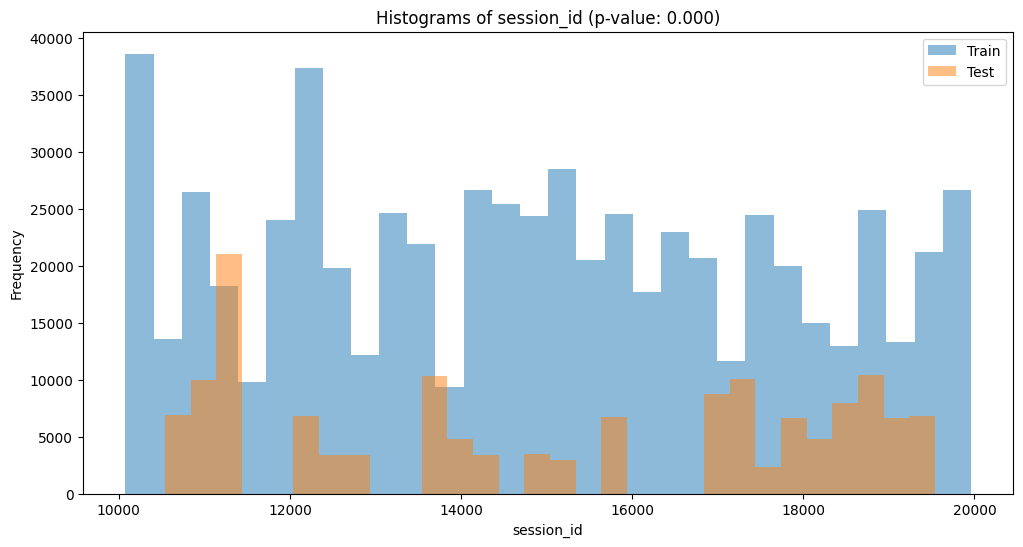

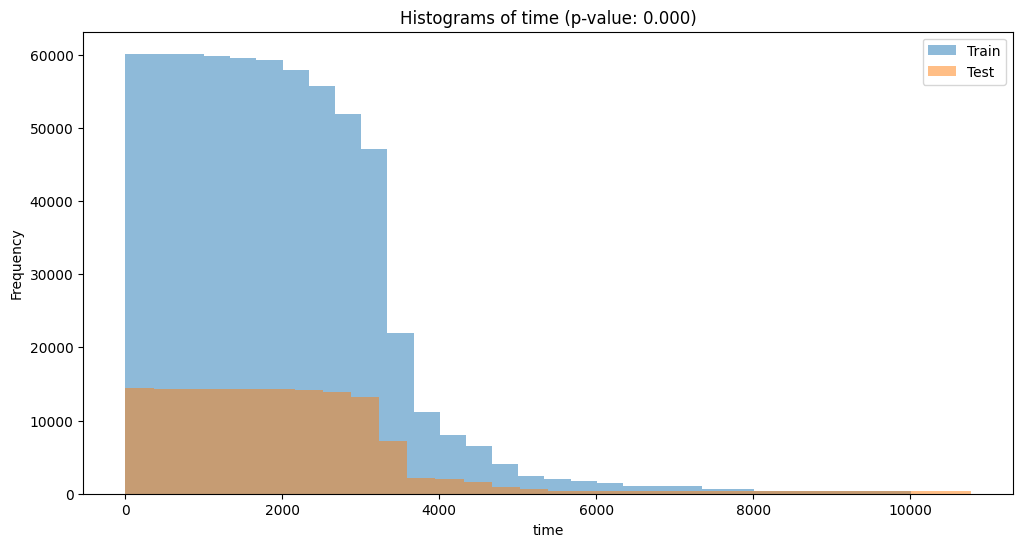

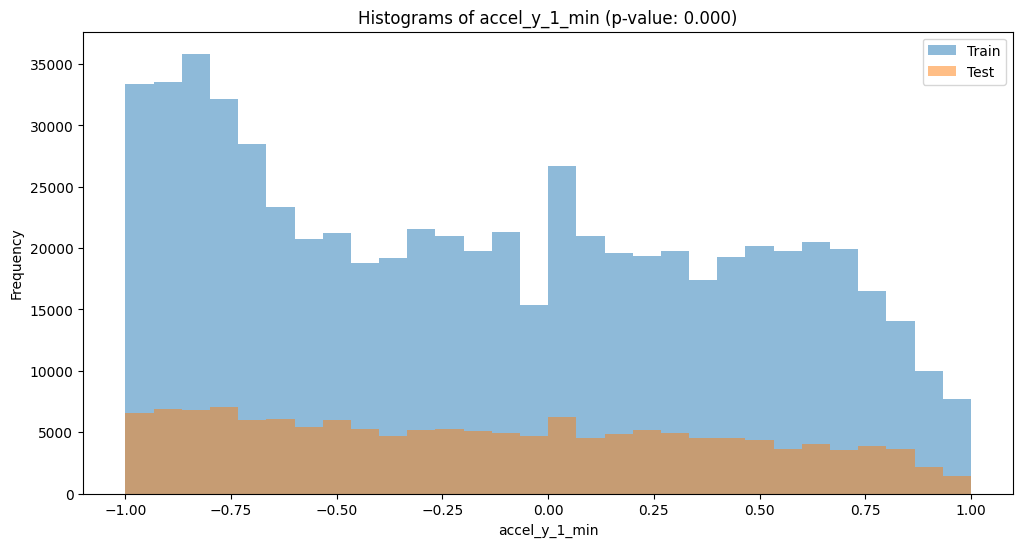

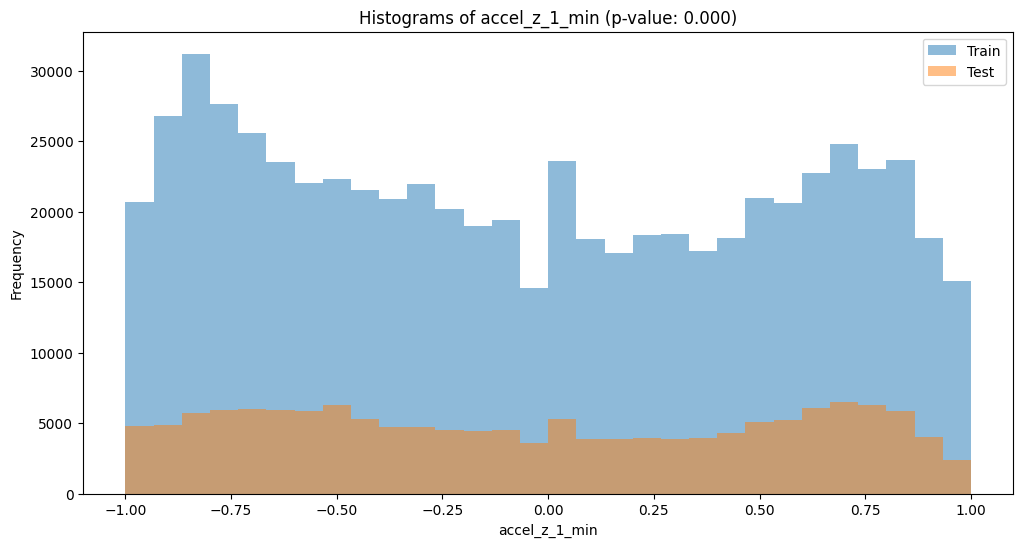

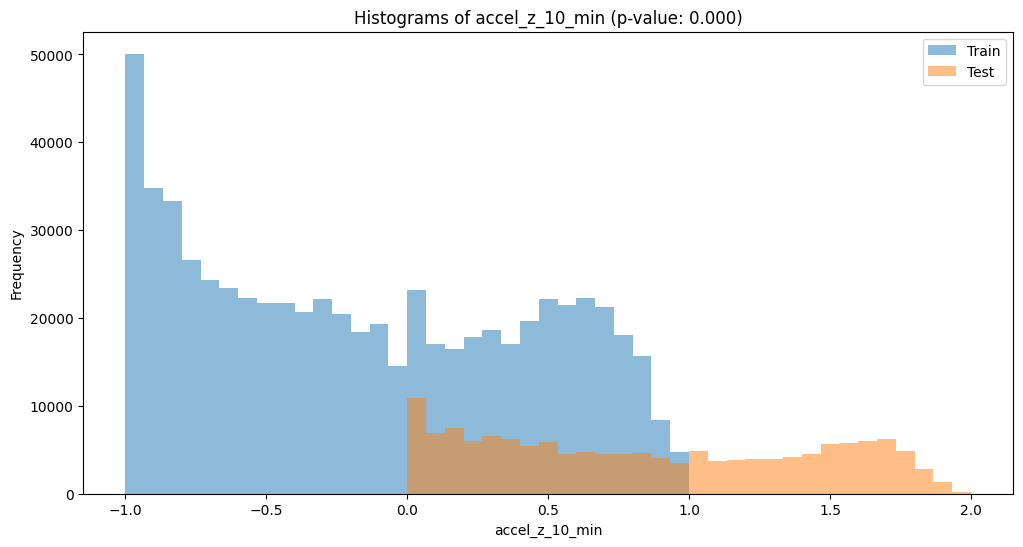

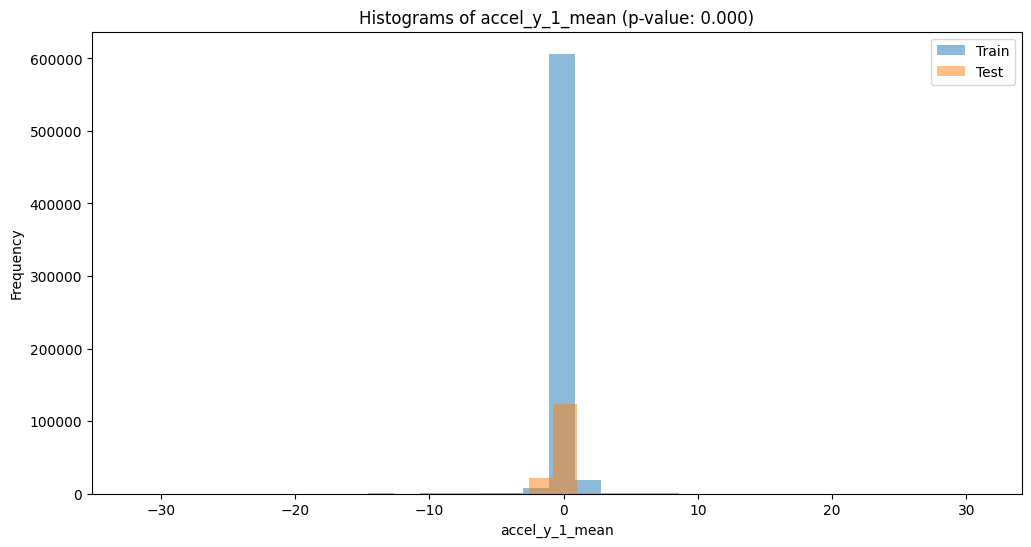

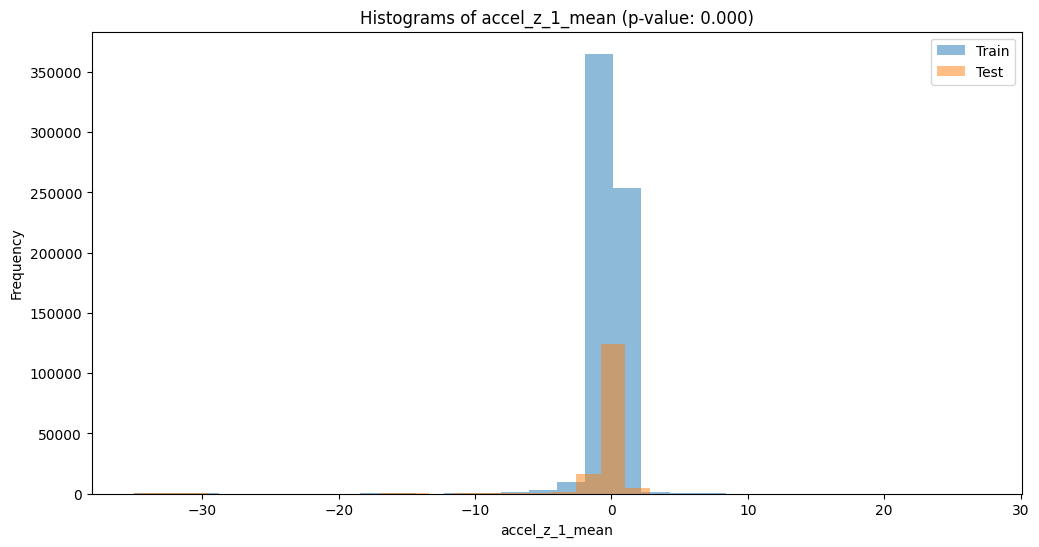

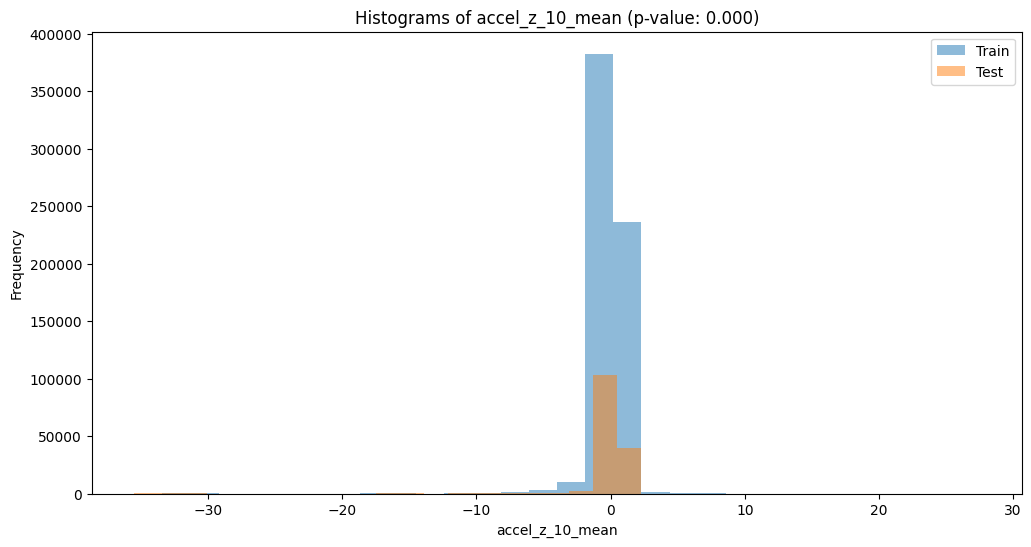

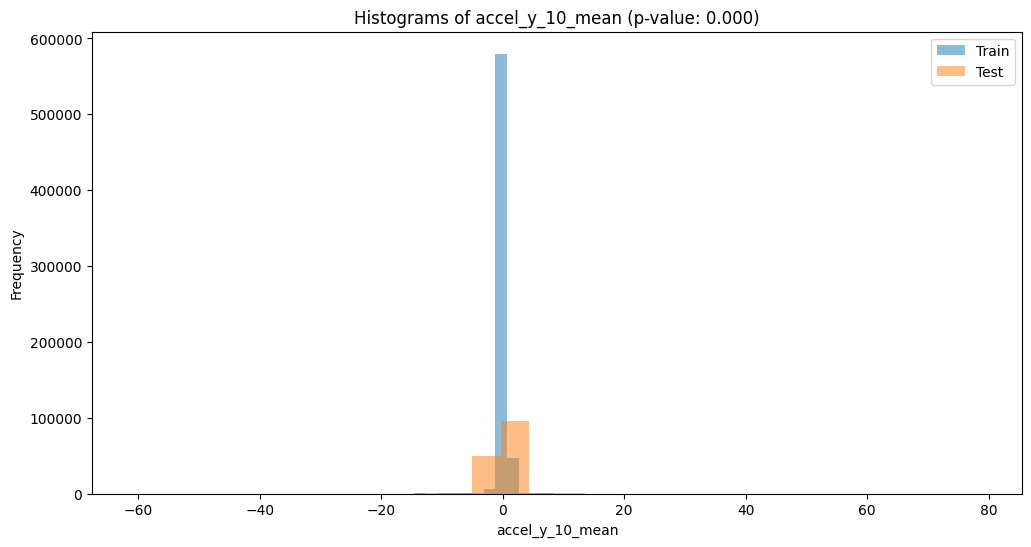

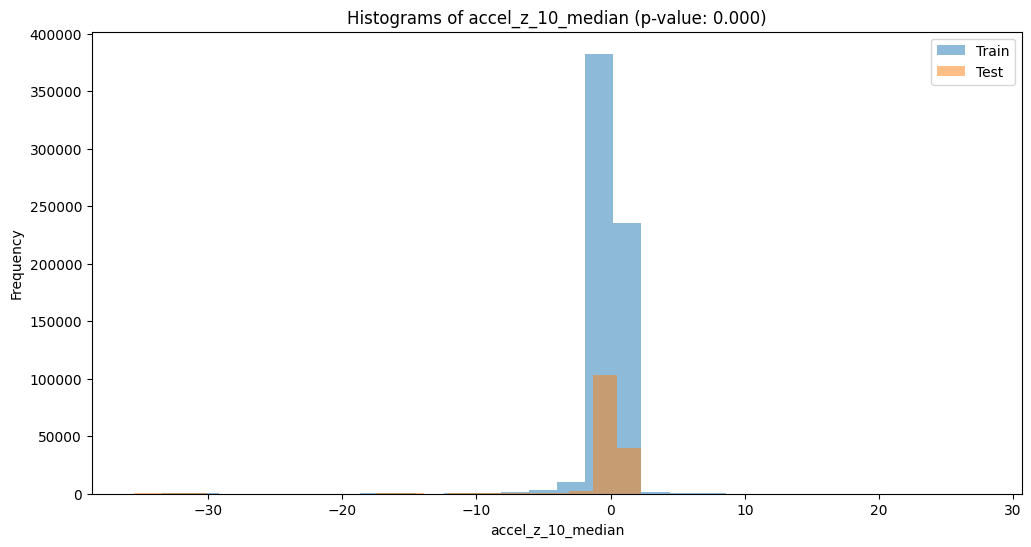

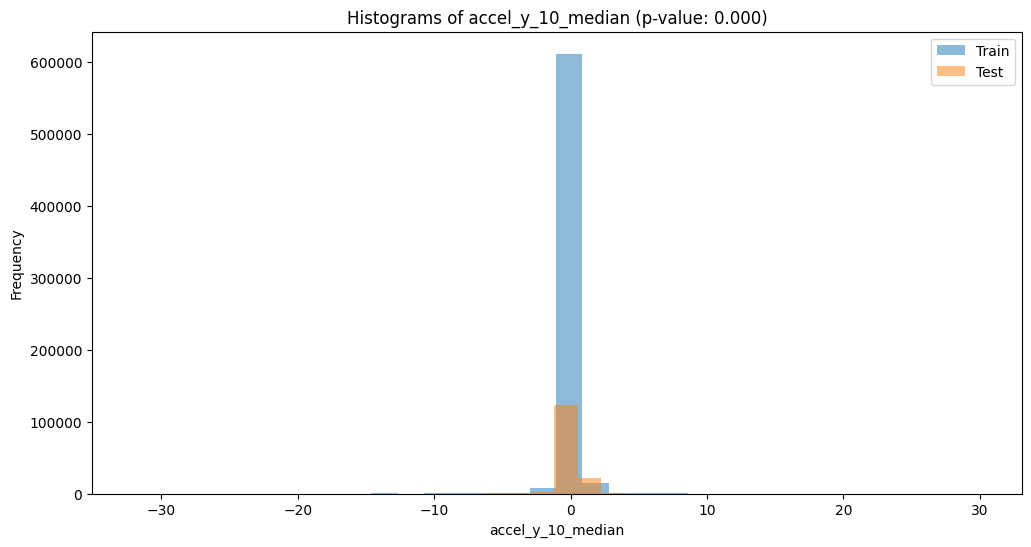

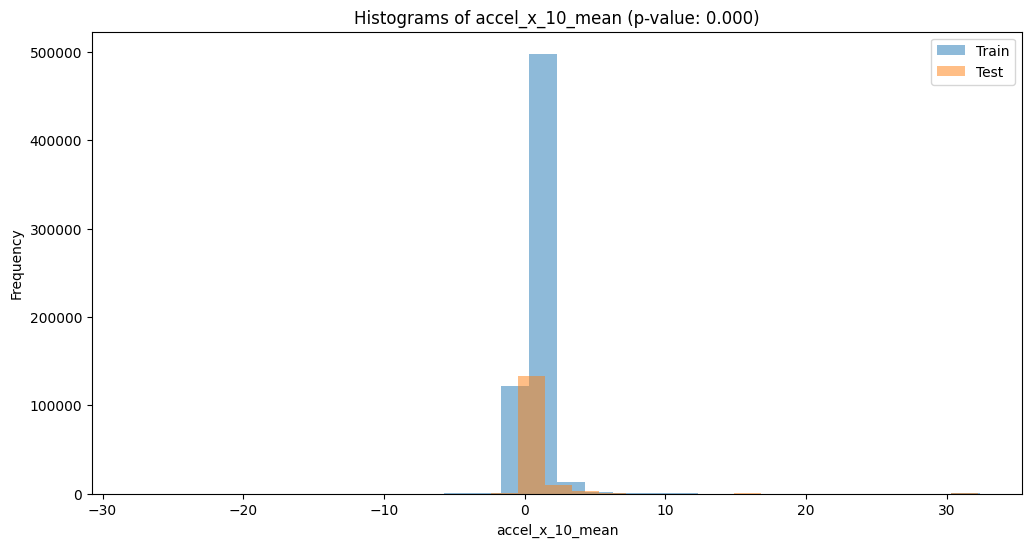

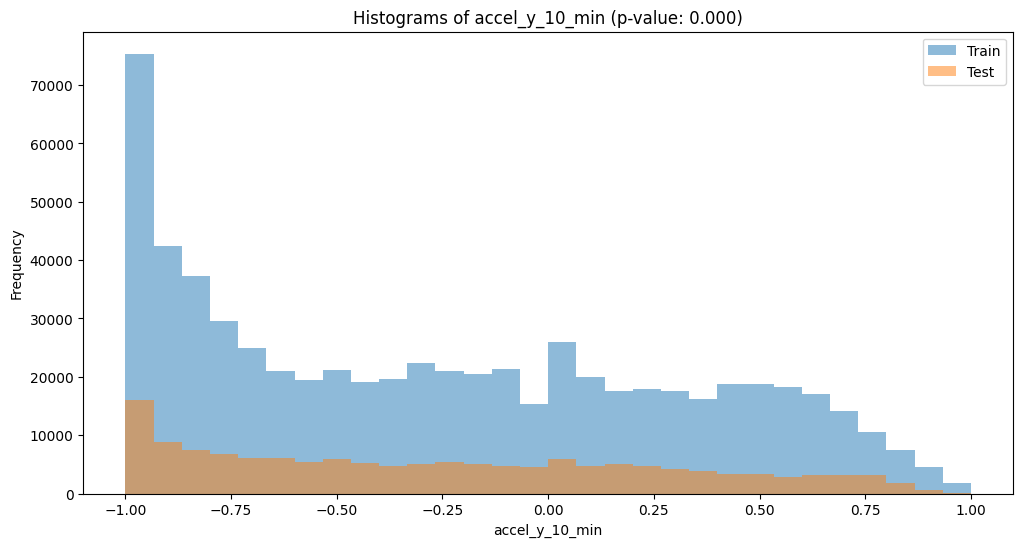

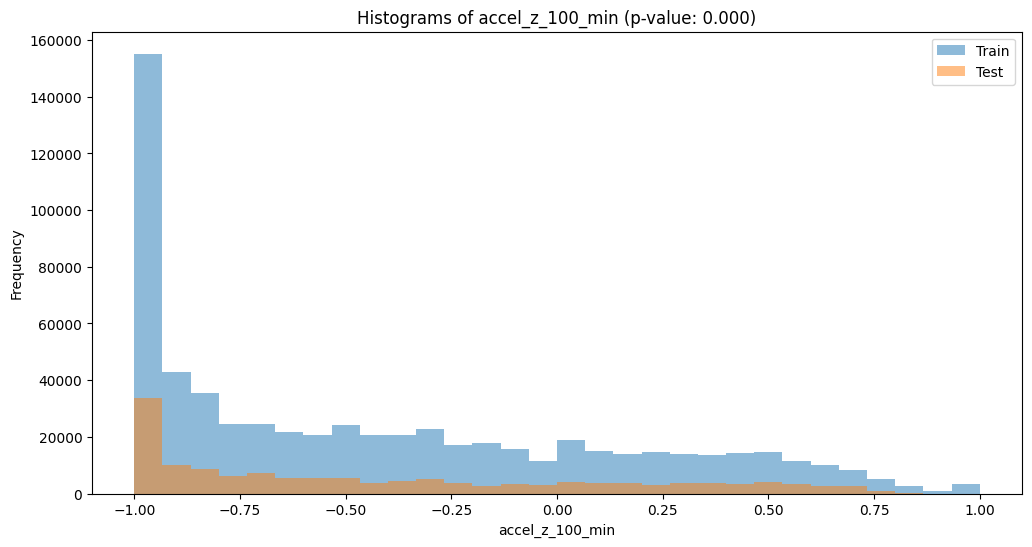

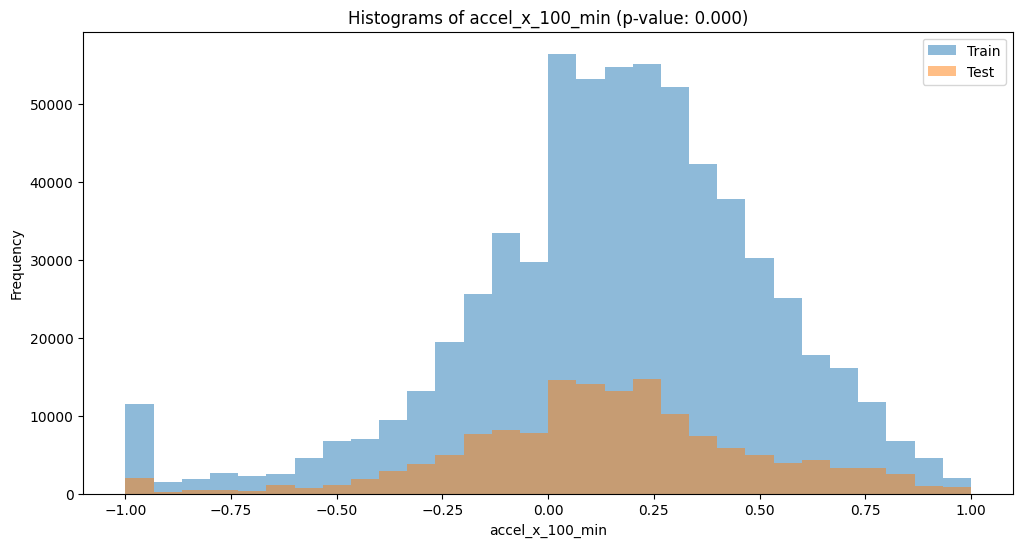

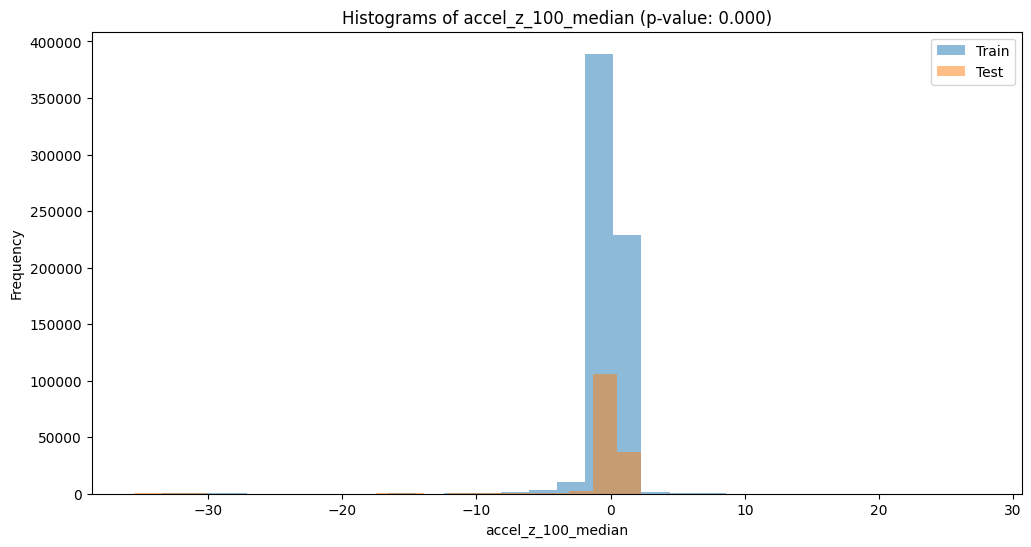

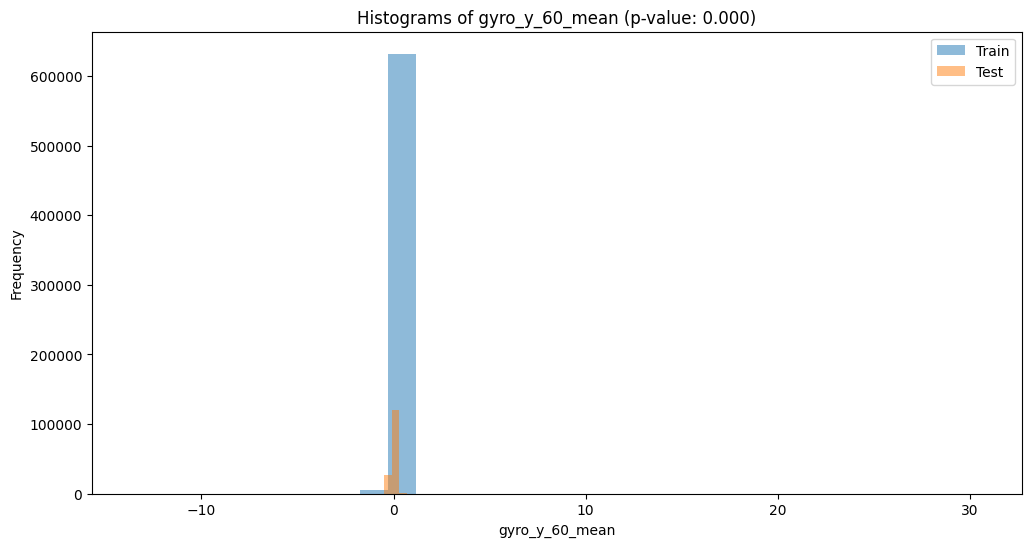

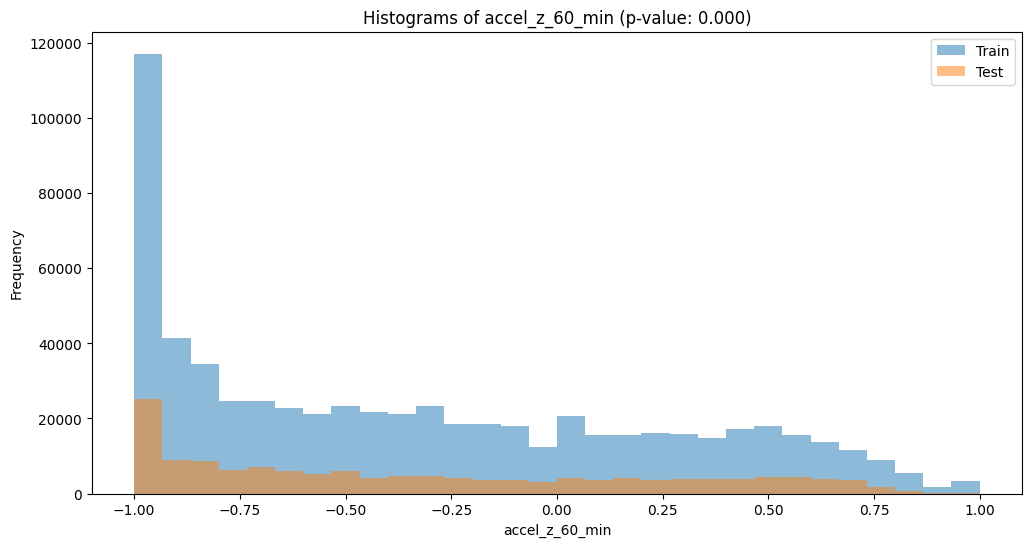

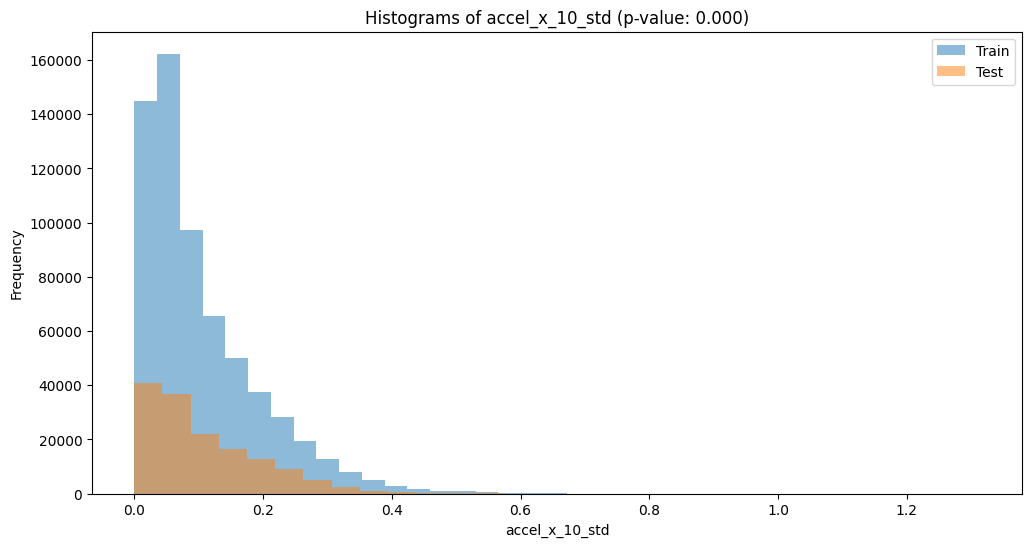

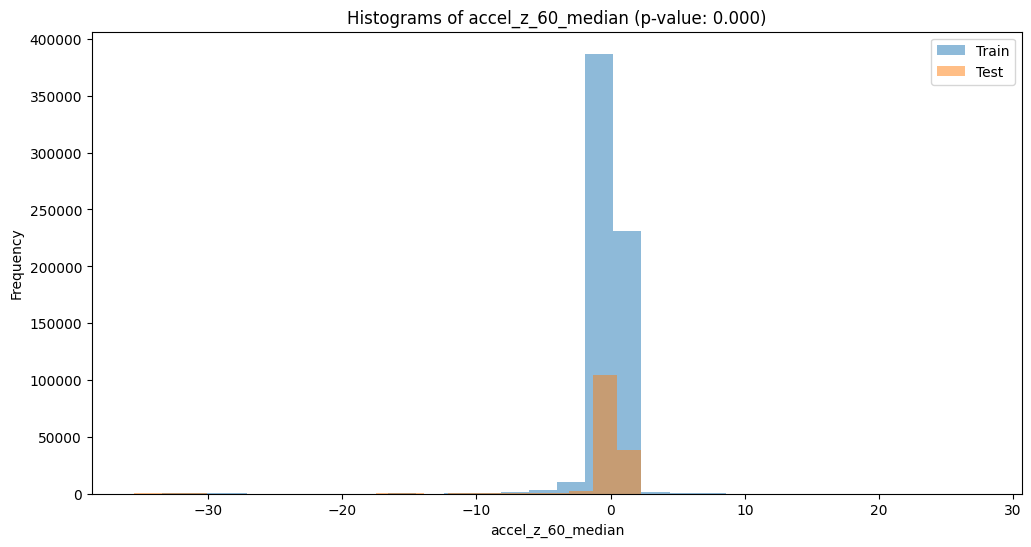

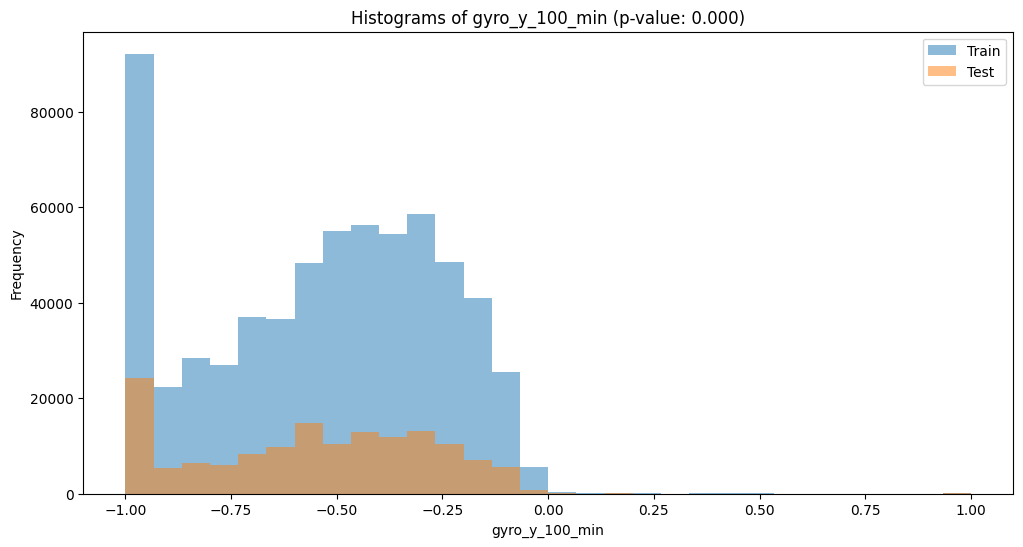

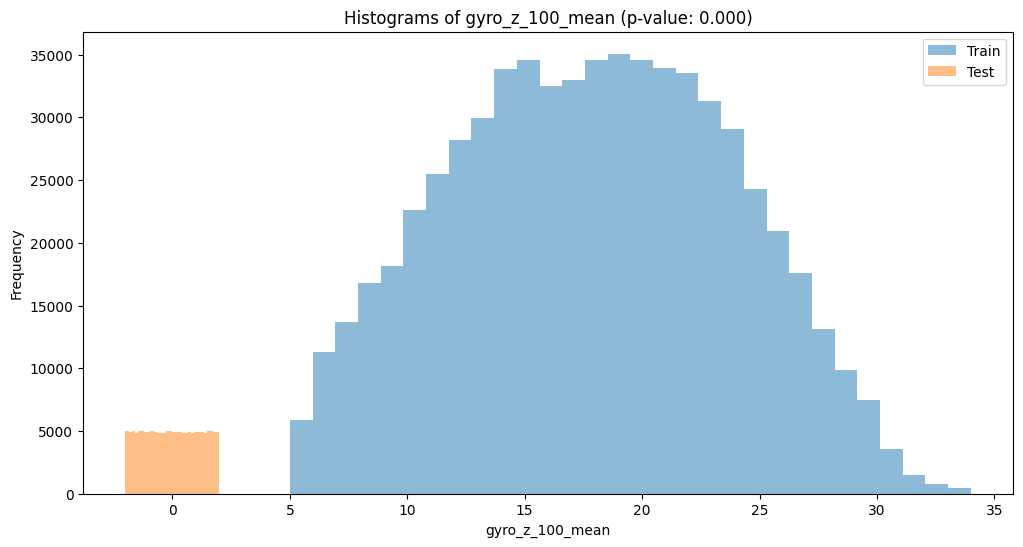

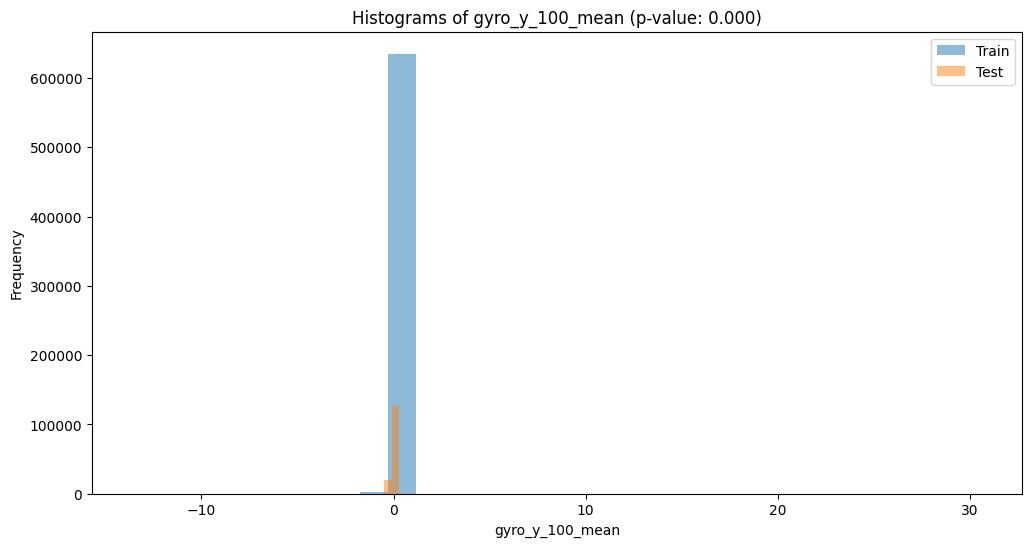

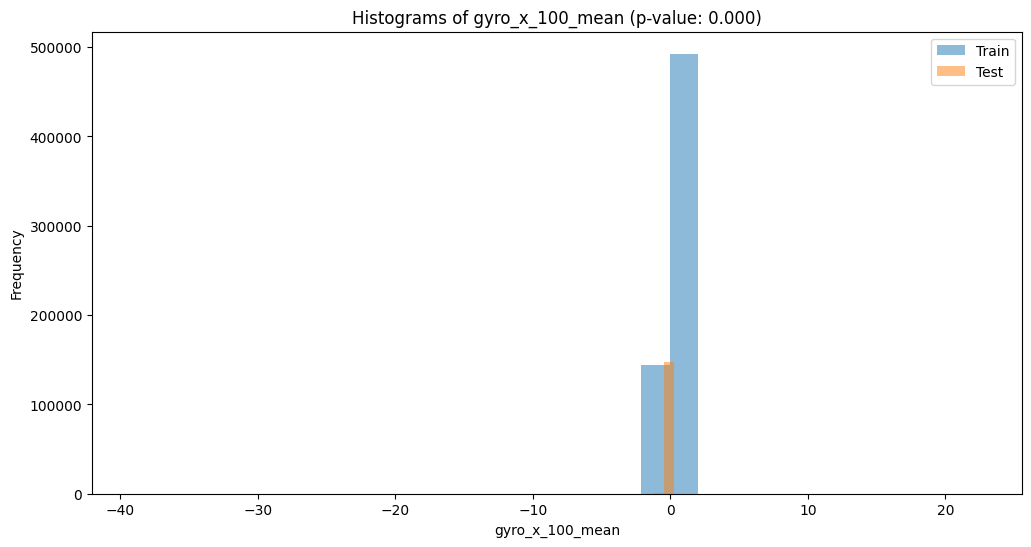

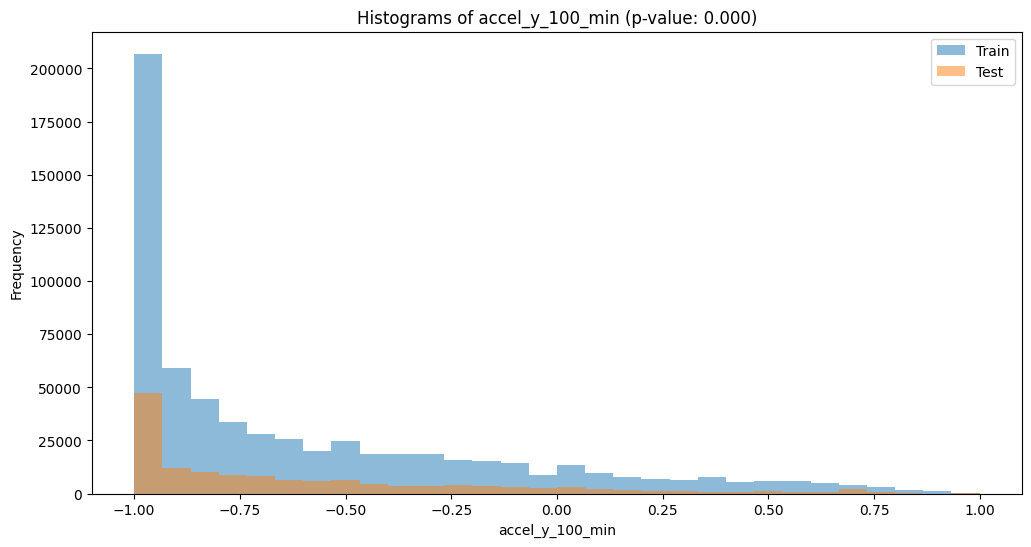

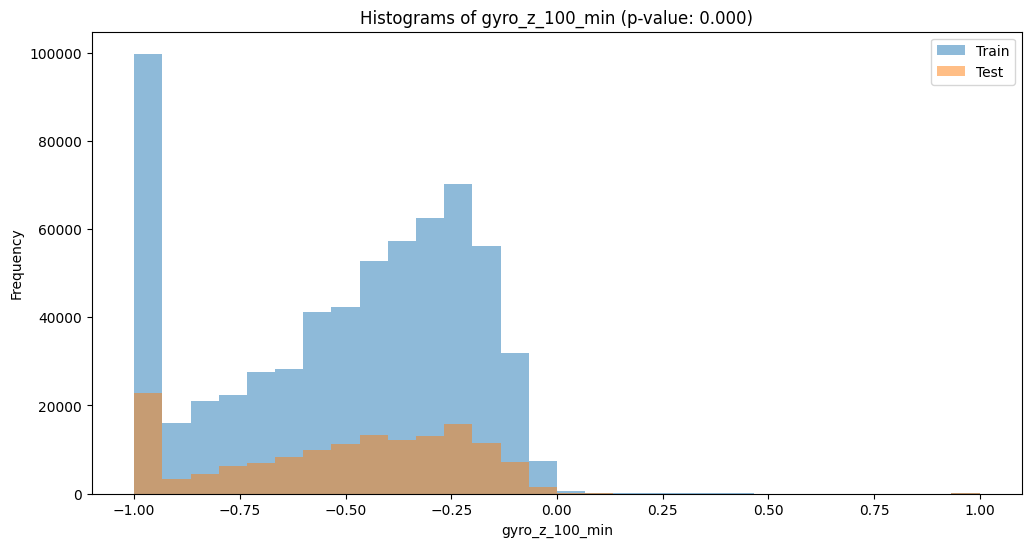

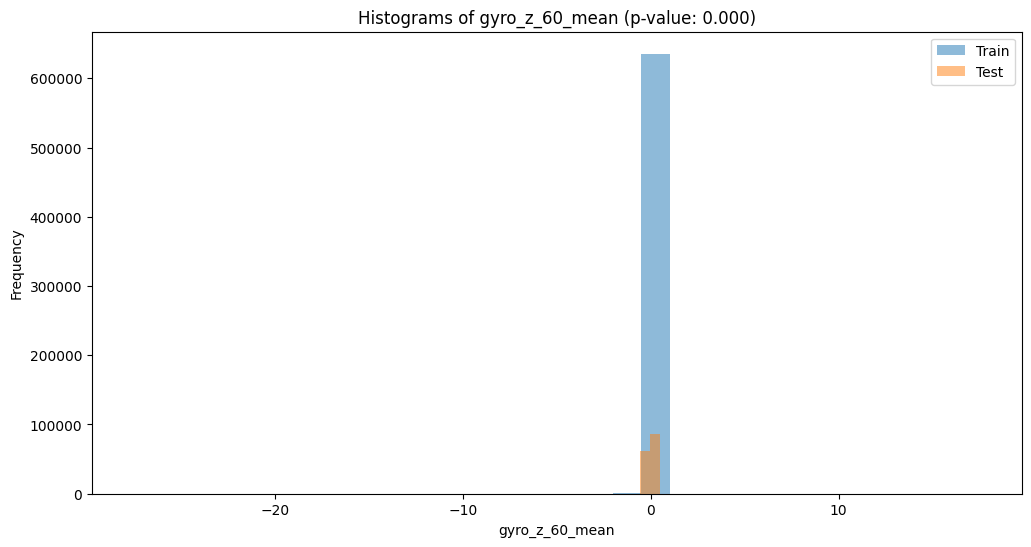

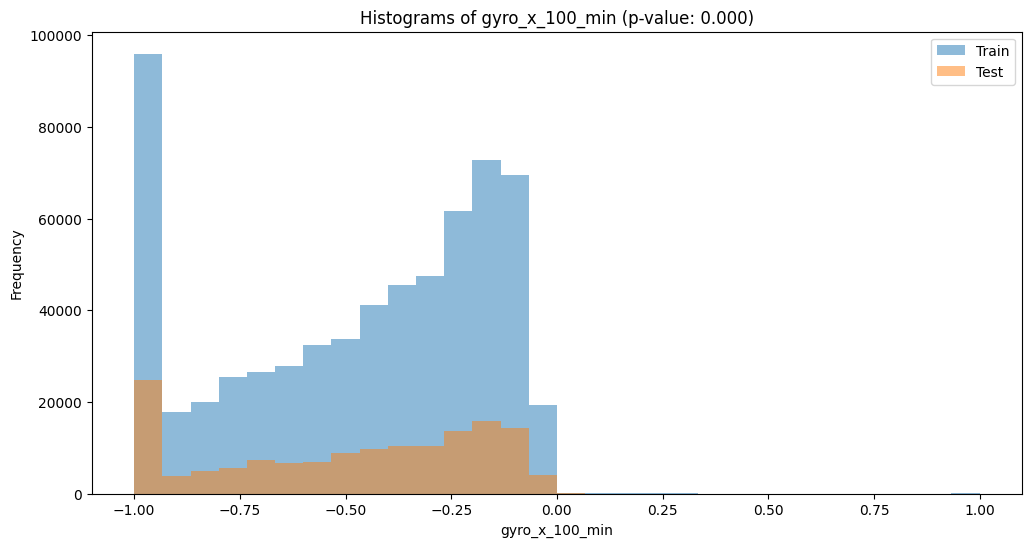

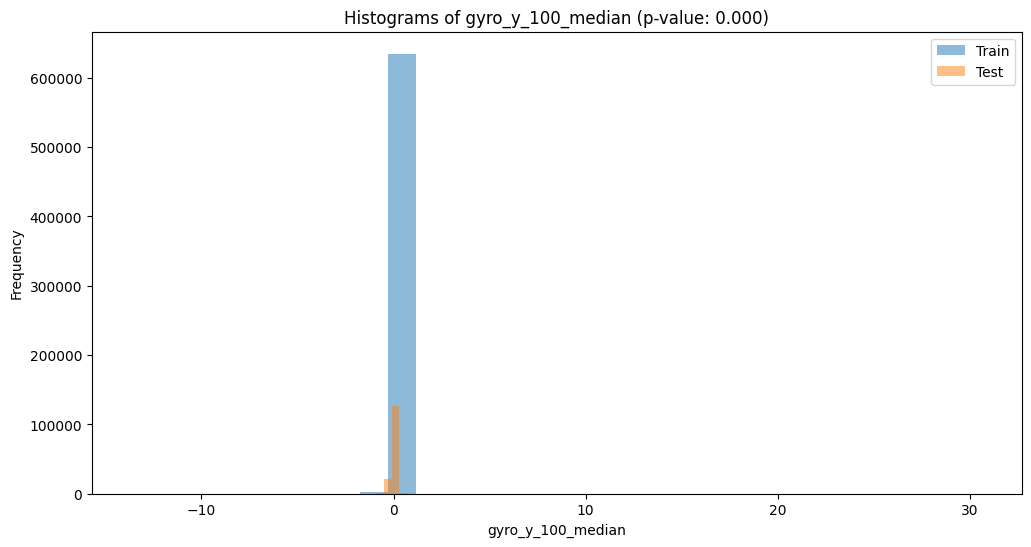

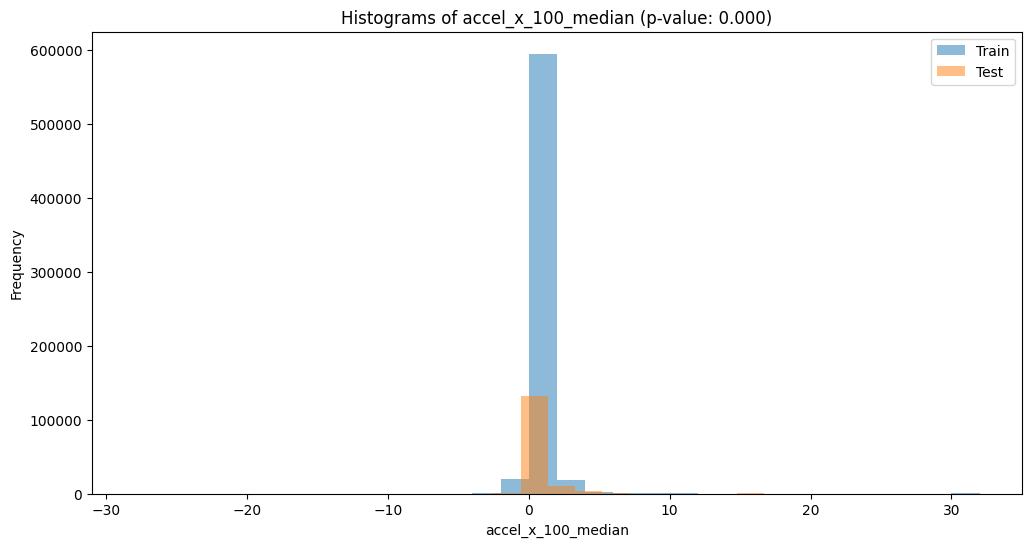

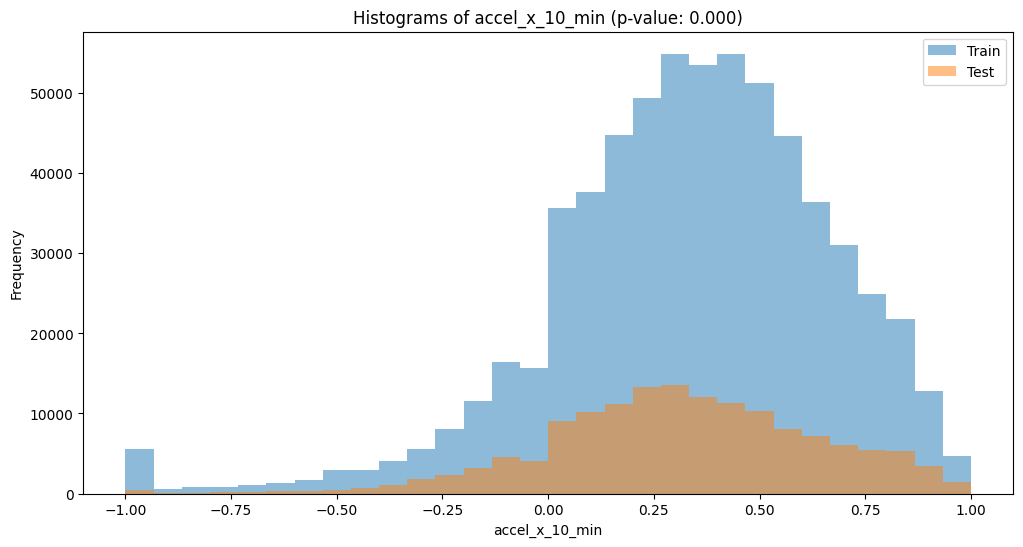

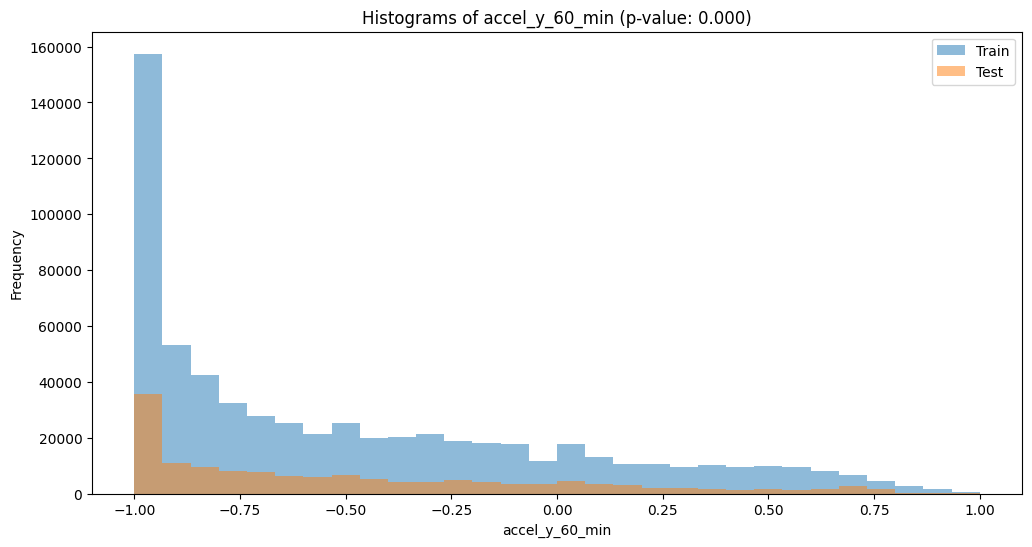

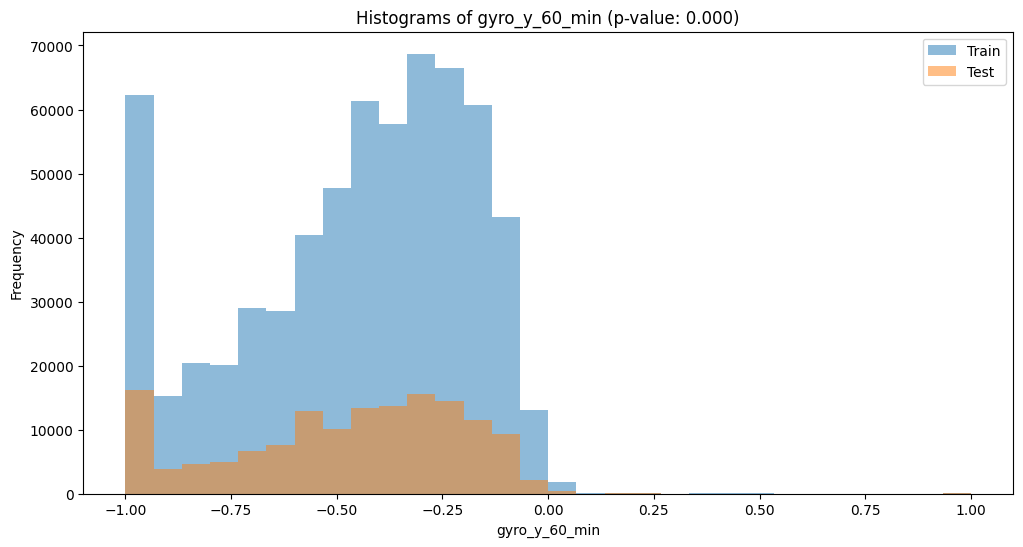

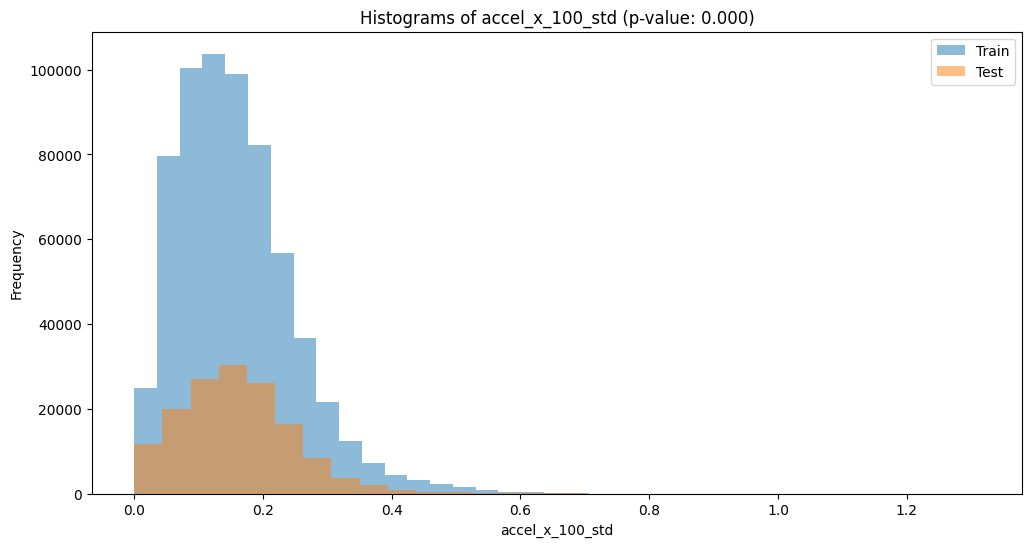

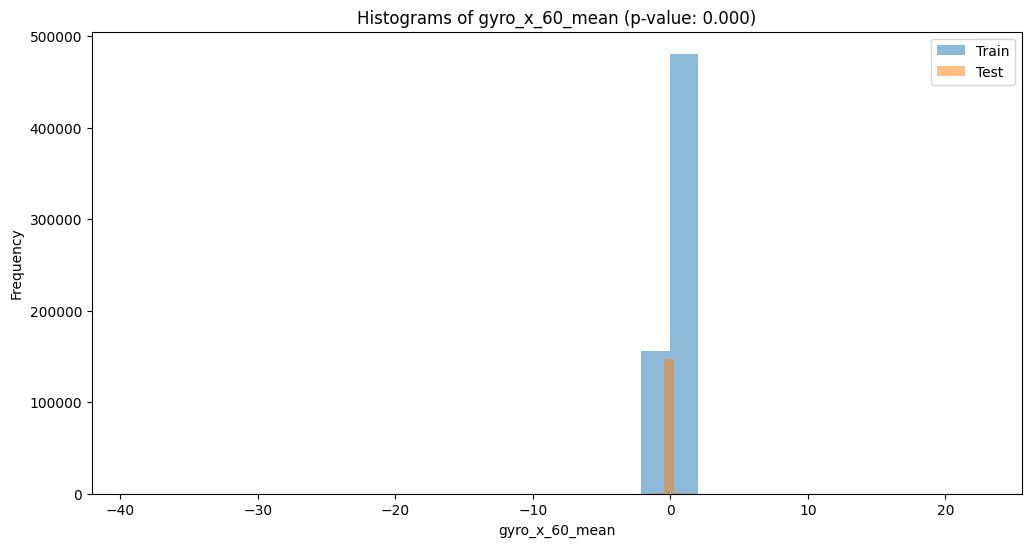

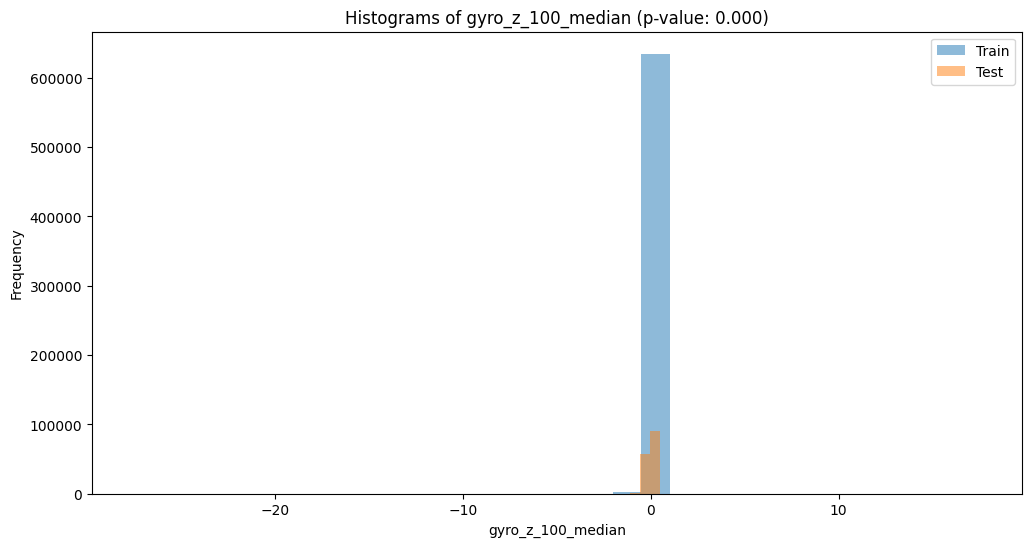

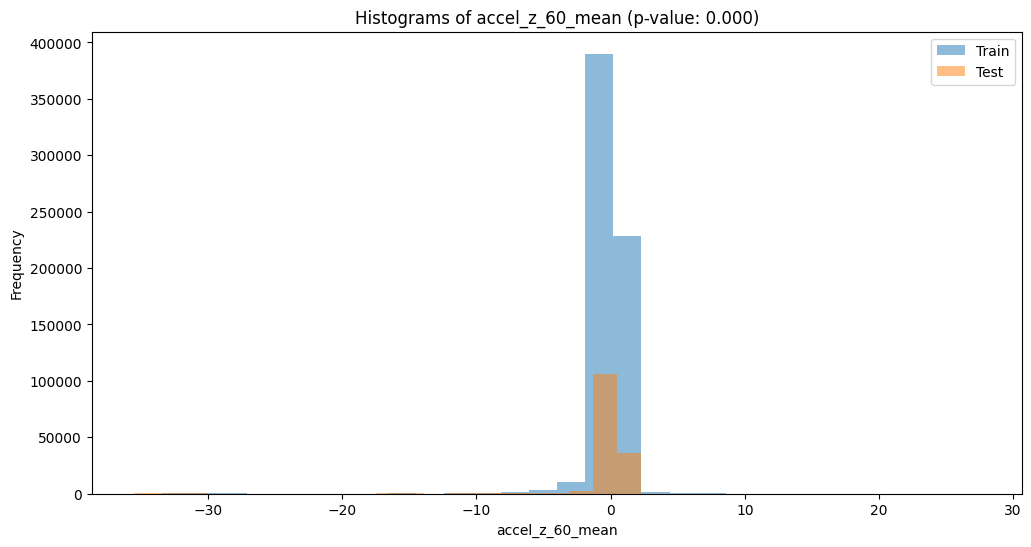

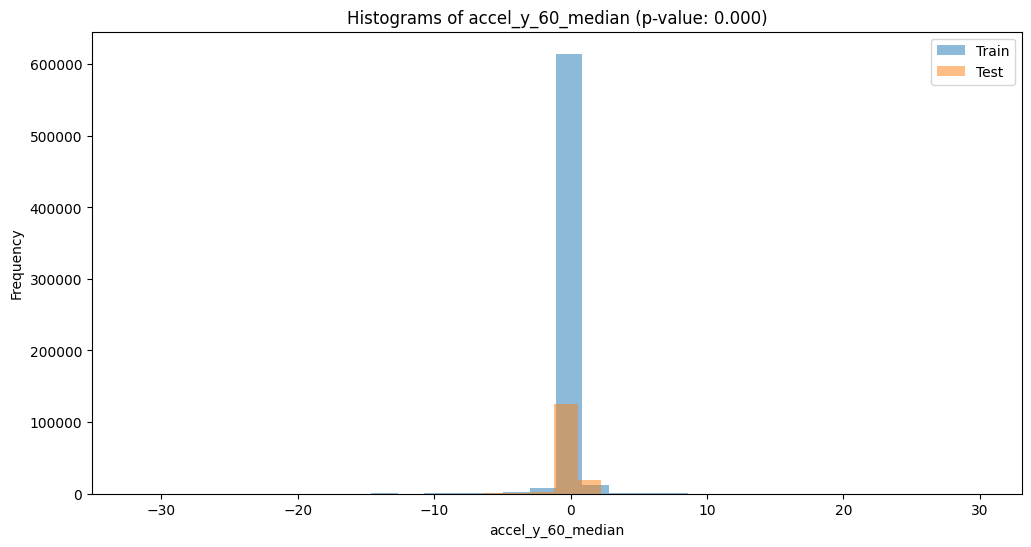

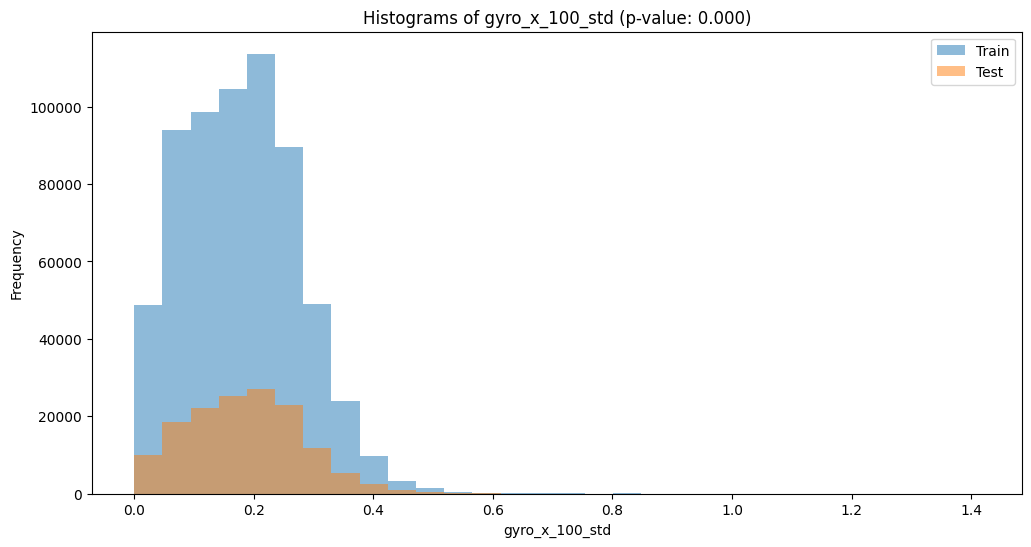


Столбцы со статистически значимыми различиями в распределении:
['session_id', 'time', 'accel_y_1_min', 'accel_z_1_min', 'accel_z_10_min', 'accel_y_1_mean', 'accel_z_1_mean', 'accel_z_10_mean', 'accel_y_10_mean', 'accel_z_10_median', 'accel_y_10_median', 'accel_x_10_mean', 'accel_y_10_min', 'accel_z_100_min', 'accel_x_100_min', 'accel_z_100_median', 'gyro_y_60_mean', 'accel_z_60_min', 'accel_x_10_std', 'accel_z_60_median', 'gyro_y_100_min', 'gyro_z_100_mean', 'gyro_y_100_mean', 'gyro_x_100_mean', 'accel_y_100_min', 'gyro_z_100_min', 'gyro_z_60_mean', 'gyro_x_100_min', 'gyro_y_100_median', 'accel_x_100_median', 'accel_x_10_min', 'accel_y_60_min', 'gyro_y_60_min', 'accel_x_100_std', 'gyro_x_60_mean', 'gyro_z_100_median', 'accel_z_60_mean', 'accel_y_60_median', 'gyro_x_100_std']


In [ ]:
numeric_cols = train_without_nun.select_dtypes(include=np.number).columns.intersection(test_without_nun.select_dtypes(include=np.number).columns)

alpha = 0.05

significantly_different_cols = []
for col in numeric_cols:
    statistic, p_value = ks_2samp(train_without_nun[col], test_without_nun[col])

    if p_value < alpha:
        significantly_different_cols.append(col)

        plt.figure(figsize=(12, 6))
        plt.hist(train_without_nun[col].dropna(), alpha=0.5, label='Train', bins=30)
        plt.hist(test_without_nun[col].dropna(), alpha=0.5, label='Test', bins=30)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Histograms of {col} (p-value: {p_value:.3f})')
        plt.legend(loc='upper right')
        plt.show()

print("\nСтолбцы со статистически значимыми различиями в распределении:")
print(significantly_different_cols)

Теперь четко видно сдвиг в выборках у таких признаков:

- gyro_z_100_mean

- accel_y_10_mean

- accel_z_10_min

Под вопросом:

- gyro_y_100_mean

- gyro_x_100_mean

- gyro_y_100_median

- gyro_x_60_mean

- gyro_y_60_mean

- gyro_z_100_median

Почти не под вопросом:

- gyro_z_60_mean

- accel_y_1_mean

- accel_x_100_median

Удалены в итоге: 'gyro_z_100_mean', 'accel_y_10_mean', 'accel_z_10_min',
Вторичные: 'gyro_y_60_mean', 'gyro_x_100_mean', 'gyro_y_100_mean'

In [ ]:
d_train, d_test = train_test_split(train, train_size = 0.75, random_state = 322, stratify = train['target'])

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=322, verbose=1)
X = d_train.drop(columns='target')
y = d_train['target']
model.fit(X, y)

KeyboardInterrupt: 

In [ ]:
importances = model.feature_importances_

feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

               feature  importance
21     gyro_z_100_mean    0.153076
1                 time    0.060575
7      accel_z_10_mean    0.030897
11     accel_x_10_mean    0.029263
5       accel_y_1_mean    0.028137
8      accel_y_10_mean    0.027765
9    accel_z_10_median    0.027700
2        accel_y_1_min    0.027297
0           session_id    0.026493
4       accel_z_10_min    0.025892
10   accel_y_10_median    0.025804
12      accel_y_10_min    0.024536
6       accel_z_1_mean    0.023554
3        accel_z_1_min    0.022183
29  accel_x_100_median    0.021623
16      gyro_y_60_mean    0.021424
14     accel_x_100_min    0.021360
26      gyro_z_60_mean    0.021124
30      accel_x_10_min    0.020914
22     gyro_y_100_mean    0.020603
36     accel_z_60_mean    0.020393
19   accel_z_60_median    0.020211
37   accel_y_60_median    0.020152
15  accel_z_100_median    0.020146
23     gyro_x_100_mean    0.019754
17      accel_z_60_min    0.019316
33     accel_x_100_std    0.019128
38      gyro_x_100_s

<Axes: >

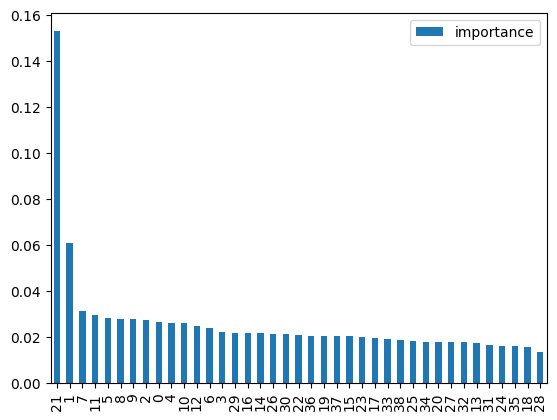

In [ ]:
feature_importances.plot.bar()